In [1]:
%tensorflow_version 2.x
# !pip install -q tensorflow_addons
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
# import tensorflow_addons as tfa



TensorFlow 2.x selected.


In [2]:
print(tf.__version__)
import pathlib

def parse_to_float_tf(line):
    splited =  tf.strings.split(line)
    return tf.compat.v2.strings.to_number(splited)

def parse_to_float(line, sep= " "):
    splited =  line.split(sep)
    return np.array([float(x) for x in splited])

def decode_img(img):
  img = tf.image.decode_png(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):    
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

2.1.0-rc1


In [3]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 8
BUFFER_SIZE = 1000
UNITS = 256


class CNN_Model(tf.keras.Model):
    def __init__(self, units):
        
        # weight=None "imagenet"
        super(CNN_Model, self).__init__()
        self.units = units
        self.conv_model = tf.keras.applications.ResNet50(weights= None, include_top=False, input_shape= (IMG_WIDTH,IMG_HEIGHT,9))
        self.pooling = layers.GlobalAveragePooling2D()
        #self.flatten = layers.Flatten()
        self.d = layers.Dense(self.units,activation="tanh")


    def call(self, x, training):
        x = self.conv_model(x)
        x = self.pooling(x)
        x = self.d(x)
        return x

class RNN_Model(tf.keras.Model):
    def __init__(self, units):
        super(RNN_Model, self).__init__()
        self.units = units
        self.gru = tf.keras.layers.LSTM(self.units,
                                       return_sequences=True,                                       
                                       recurrent_initializer='glorot_uniform',
                                       name='rnn_gru_0')
        self.gru2 = tf.keras.layers.LSTM(128,
                                       return_sequences=True,
                                       recurrent_initializer='glorot_uniform',
                                       name='rnn_gru_1')
        self.d1 = tf.keras.layers.Dense(self.units, activation='relu', name='rnn_dense_0_1')
        self.d21 = tf.keras.layers.Dense(3, activation='tanh', name='rnn_dense_1_0')
        self.d22 = tf.keras.layers.Dense(1, activation='sigmoid', name='rnn_dense_1_1')

    def call(self, x, state, mask, training):
        out = self.gru(x,initial_state=state,mask=mask,training=training)
        out = self.gru2(out,mask=mask,training=training)
        x = self.d1(out)
        return self.d21(x), self.d22(x), state


CNN = CNN_Model(UNITS)
RNN = RNN_Model(UNITS)



/tensorflow-2.1.0/python3.6/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 9 input channels.
  str(input_shape[-1]) + ' input channels.')


In [0]:

optimizer = tf.keras.optimizers.Adam()
bce = tf.keras.losses.BinaryCrossentropy(reduction='none')

@tf.function
def bce_loss(predicted, target,mask):
    #mask = tf.math.logical_not(tf.math.equal(target, 0))
    loss_ = bce(target,predicted)
    #mask = tf.cast(mask, dtype=loss_.dtype)
    #loss_ *= mask
    return tf.reduce_mean(loss_)
@tf.function
def mse_loss(predicted, target,mask):    
    #mask = tf.math.logical_not(tf.math.equal(target, 0))
    loss_ = tf.square(predicted - target)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
print(tf.executing_eagerly())
import pathlib

data_dir = "drive/My Drive/gsn_data/dataset"
data_dir = pathlib.Path(data_dir)

def load_dataset_images(paths,vertices):    
    images = []
    return paths, vertices

def load_lines():
    lines_seqs=[]
    masks=[] 
    lenghts = []
    max_len = 0
    for i,item in enumerate(data_dir.glob("*")):
        list_ds = tf.data.Dataset.list_files(str(item)+"/*.txt")
        lines = []
        for f in list_ds.take(1):
            with open(f.numpy()) as v:
                for line in v:                
                    lines.append(parse_to_float(line))
        if len(lines)>max_len:
            max_len=len(lines)
        lines_seqs.append(lines)
        masks.append(np.ones(len(lines), dtype=bool))
        lenghts.append(len(lines))

    for i in range(len(masks)):
        masks[i] = np.pad(masks[i],(0,max_len-len(masks[i])),'constant') 
 
    lines_padded = tf.keras.preprocessing.sequence.pad_sequences(lines_seqs, padding='post',maxlen=max_len,dtype='float32')
    return lines_padded,masks,lenghts


def load_images_paths():
    images_paths=[]
    for item in data_dir.glob("*"):
        images =  [str(item)+f"/{i}.png" for i in range(3)]
        images_paths.append([images[0],images[1],images[2]])
  
    return images_paths
def gen():
    #print("START")
    for item in data_dir.glob("*"):
        list_ds = tf.data.Dataset.list_files(str(item)+"/*.txt")
        # images_paths = [str(p) for p in item.glob("*.png")]
        list_images = tf.data.Dataset.list_files(str(item)+"/*.png")
        images = [img for img in list_images.take(3)]
        
        lines = []
        for f in list_ds.take(1):
            with open(f.numpy()) as v:
                for line in v:                
                    lines.append(parse_to_float(line))
        # yield (features,lines,len(lines))
        yield images[0],images[1],images[2],lines,len(lines)

def map_func(path1, path2, path3, vertices, length):    
    img1 = tf.io.read_file(path1)
    img1 = decode_img(img1)
    img2 = tf.io.read_file(path2)
    img2 = decode_img(img2)
    img3 = tf.io.read_file(path3)
    img3 = decode_img(img3)
    return img1,img2,img3,vertices,length

def map_func2(paths, vertices):    
    img1 = tf.io.read_file(paths[0])
    img1 = decode_img(img1)
    img2 = tf.io.read_file(paths[1])
    img2 = decode_img(img2)
    img3 = tf.io.read_file(paths[2])
    img3 = decode_img(img3)
    return img1,img2,img3,vertices
    

vertices_list = load_lines()
images_list = load_images_paths()

dataset = tf.data.Dataset.from_tensor_slices((images_list,vertices_list))
rest = dataset.skip(1500).map(map_func2)
dataset = dataset.take(1500) 
dataset = dataset.shuffle(1000).map(map_func2).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [0]:
@tf.function
def train_step(img_tensor, target,mask,length,training):
    loss = 0

    dummy_featues = tf.ones((target.shape[0],target.shape[1], UNITS))
    # embedding = layers.Embedding(input_dim=5000, output_dim=16, mask_zero=True)
    # mask1 = embedding.compute_mask(target)
  
    with tf.GradientTape() as tape:
        
        cnn_out = CNN(img_tensor,training)
        hidden_state = [cnn_out, tf.zeros((target.shape[0], UNITS))]
        out1, out2, hidden_state = RNN(dummy_featues,hidden_state,mask,training)
        

        loss += chamfer_distance_tf(out1,target[:, :, :3],length)
        # loss += mse_loss(out1,target[:, :,:3],mask1[:,:,:3])
        loss += bce_loss(out2, target[:, :, 3], mask)

    total_loss = loss/int(target.shape[1])

    #print("Losses:",total_loss,loss)
    trainable_vars = CNN.trainable_variables + RNN.trainable_variables 
    grad = tape.gradient(loss, trainable_vars)
    optimizer.apply_gradients(zip(grad,trainable_vars))
    loss= loss*1000

    return loss, total_loss

In [0]:
import os
import shutil
EPOCHS = 50

losses = []

for epoch in range(EPOCHS):
    # start = time.time()
    total_loss = 0

    for (batch, (img1,img2,img3,(target,mask,length))) in enumerate(dataset):
        img_tensor = tf.concat([img1,img2,img3], axis=3)
        b_loss, t_loss = train_step(img_tensor, target,mask,length,True)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, b_loss.numpy() / int(target.shape[1])))

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,total_loss))
    losses.append(total_loss)

CNN.save_weights('./checkpointsC1/cpCNN.ckpt')
RNN.save_weights('./checkpointsR1/cpRNN.ckpt')

In [20]:
import pathlib
import numpy as np
max_length = 1010

def evaluate(path):
    # CNN.load_weights('./checkpointsCfinal/cpCNN.ckpt')   
    # RNN.load_weights('./checkpointsRfinal/cpRNN.ckpt')
    test_dir = pathlib.Path(path)
    images = []
    xt=[]
    yt=[]
    zt=[]
    for i,item in enumerate(test_dir.glob("*.png")):
        print(str(item))
        img = tf.io.read_file(str(test_dir)+f"/{i}.png")
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
        images.append(img)
    for i,item in enumerate(test_dir.glob("*.txt")):
        with open(str(item)) as v:
            for line in v:
                vxs = parse_to_float(line)
                xt.append(vxs[0])
                yt.append(vxs[1]) 
                zt.append(vxs[2])           
                    
    print(len(images))    
    if len(images) !=3:
        raise Exception("Wrong number of images")
    input_images = np.concatenate(images,axis=2)
    input_images = tf.expand_dims(input_images,0)
    dummy_featues = tf.ones((1,max_len, UNITS))
    mask = tf.ones((1,max_len, UNITS),dtype=tf.bool)
    hidden_state = CNN(input_images,False)
    hidden_state = [hidden_state, tf.zeros((1, UNITS))]
   
    out1, out2, hidden_state = RNN(dummy_featues,hidden_state,None,False)

    result = []
    x=[]
    y=[]
    z=[]
    end = np.argmax(out2.numpy()[0])
    print(end,len(xt))
    print(np.max(out2.numpy()[0]))
    with open("rmse_v_test3.txt",'w') as f:
        for i in range(end):
            l = out1.numpy()[0][i]
            f.write(f'{l[0]},{l[1]},{l[2]}\n')
            x.append(l[0])
            y.append(l[1])
            z.append(l[2])

    return x,y,z,xt,yt,zt
xs,ys,zs,xt,yt,zt= evaluate("test")

test3/0.png
test3/2.png
test3/1.png
3
999 64
0.0050867437


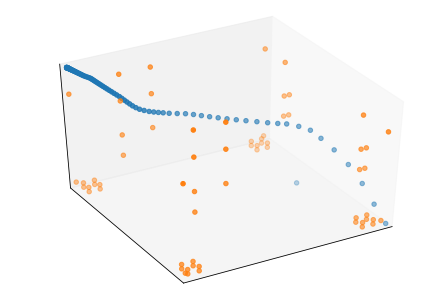

In [21]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import axes3d, Axes3D 

def n(p):
    pmax = np.max(p)
    pmin = np.min(p)
    df = pmax-pmin
    return list(map(lambda x :(x-pmin)/df, p))

fig = plt.figure()
i=100
ax = Axes3D(fig)
ax.view_init(elev=40, azim=60)

ax.grid(False)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.scatter(zs[:i],xs[:i],ys[:i],  marker="o")
ax.scatter(zt,xt, yt,  marker="o")

plt.show()

_________________________________________________________________________
_________________________________________________________________________
_________________________________________________________________________
_________________________________________________________________________
_________________________________________________________________________




In [0]:
def distance_matrix(array1, array2,length):

    # num_point, num_features = array1.shape
    expanded_array1 = tf.tile(array1, (length, 1))
    expanded_array2 = tf.reshape(
                        tf.tile(
                            tf.expand_dims(array2, 1), 
                        (1, length, 1)),
                    (-1, 3))
    distances = tf.norm(expanded_array1-expanded_array2, axis=1)
    distances = tf.reshape(distances, (length, length))
    return distances

def av_dist(array1, array2, length):

    distances = distance_matrix(array1, array2,length)
    distances = tf.reduce_min(distances, axis=1)
    distances = tf.reduce_mean(distances)
    return distances

def av_dist_sum(arrays):

    array1, array2, length = arrays
    array1 = array1[:length,:]
    array2 = array2[:length,:]
    av_dist1 = av_dist(array1, array2,length)
    av_dist2 = av_dist(array2, array1,length)
    return av_dist1+av_dist2


def chamfer_distance_tf(array1, array2, lengths):
    dist = tf.reduce_mean(
               tf.map_fn(av_dist_sum, elems=(array1, array2, lengths), dtype=tf.float32)
           )
    return dist

In [24]:
#Test dataset eval

test_losses = []
length_diff = []
CNN.load_weights('./checkpointsCfinal/cpCNN.ckpt')   
RNN.load_weights('./checkpointsRfinal/cpRNN.ckpt')
for (batch, (img1,img2,img3,(target,mask,length))) in enumerate(rest):
    loss= 0
    img_tensor = tf.concat([img1,img2,img3], axis=2)
    img_tensor = tf.expand_dims(img_tensor,0)
    target = tf.expand_dims(target,0)
    mask = tf.expand_dims(mask,0)
    # length = tf.expand_dims(length,0)

    dummy_featues = tf.ones((target.shape[0],target.shape[1], UNITS))

    hidden_state = CNN(img_tensor,False)
    hidden_state = [hidden_state, tf.zeros((target.shape[0], UNITS))]
    out1, out2, hidden_state = RNN(dummy_featues,hidden_state,mask,False)
    
    seq_end = np.argmax(out2.numpy()[0])
    length_diff.append(seq_end-length.numpy())

    loss += chamfer_distance_tf(out1,target[:, :, :3],length)
    loss += bce_loss(out2, target[:, :, 3], mask)
    total_loss = loss/int(target.shape[1])
    test_losses.append(total_loss)


[-70, -480, -275, -220, -9, -121, -220, -29, -86, -157, -349, -72, -87, -161, -2, -11, -9, -170, -151, -239, -40, -447, -196, -208, -736, -30, -301, -7, -213, -395, -609, -231, -7, -71, -564, -383, -169, -29, -411, -358, -297, -593, -7, -96, -159, -302, -1, -86, -65, -111, -7, -249, -571, -235, -7, -346, -170, -61, -1, -199, -231, -43, -3, -94, -153, -135, -26, -7, -74, -7, -7, -132, -521, -71, -288, -100, -263, -273, -105, -261, -558, -109, -74, -264, -158, -86, -7, -2, -183, -94, -565, -1, -25, -14, -149, -1, -163, -15, -20, -223, -1, -330, -1, -495, -255, -577, -1, -191, -394, -190, -144, -390, -207, -314, -23, -157, -87, -35, -188, -115, -8, -269, -293, -1, -51, -249, -97, -63, -105, -9, -106, -310, -293, -808, -123, -110, -116, -19, -215, -1, -239, -59, -449, -1, -370, -55, -172, -777, -1, -461, -469, -360, -53, -102, -215, -40, -201, -276, -1, -90, -356, -16, -309, -15, -10, -70, -65, -211, -2, -11, -50, -119, -246, -70, -249, -387, -50, -7, -27, -37, -356, -767, -193, -104, -177

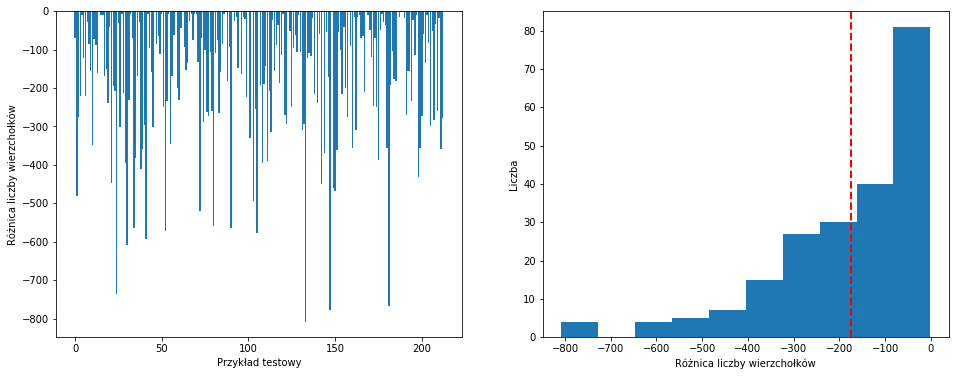

In [40]:
np.mean(length_diff)
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(1, 2, 1)
ax.bar(range(len(length_diff)),length_diff)
ax.set_ylabel("Różnica liczby wierzchołków")
ax.set_xlabel("Przykład testowy")

ax = fig.add_subplot(1, 2, 2)
ax.hist(length_diff)
plt.axvline(np.mean(length_diff), color='red', linestyle='dashed', linewidth=2)

ax.set_xlabel("Różnica liczby wierzchołków")
ax.set_ylabel("Liczba")
plt.savefig("diff.png")
plt.show()

0.0419534407556057


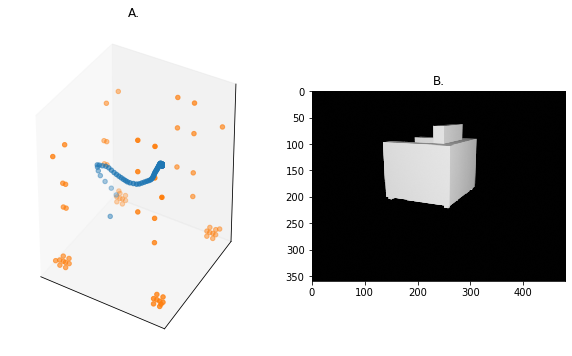

In [27]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

from mpl_toolkits.mplot3d.axes3d import get_test_data
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

files = ['rmse_v_test3.txt']
files2 = ['test3/v.txt']
def n(p):
    pmax = np.max(p)
    pmin = np.min(p)
    df = pmax-pmin
    return list(map(lambda x :(x-pmin)/df, p))

predicted=[]
truth = []
for i in range(len(files)):
    xx = []
    yy=[]
    zz=[]
    vertices=[]
    with open(files[i],'r') as fp:
        for line in fp:
            vxs = parse_to_float(line,sep=",")
            xx.append(vxs[0])
            yy.append(vxs[1]) 
            zz.append(vxs[2])
    vertices.append(xx)
    vertices.append(yy)
    vertices.append(zz)
    predicted.append(vertices)

for i in range(len(files2)):
    xx = []
    yy=[]
    zz=[]
    vertices=[]
    with open(files2[i],'r') as fp:
        for line in fp:
            vxs = parse_to_float(line,sep=" ")
            xx.append(vxs[0])
            yy.append(vxs[1]) 
            zz.append(vxs[2])
    vertices.append(xx)
    vertices.append(yy)
    vertices.append(zz)
    truth.append(vertices)

fig = plt.figure(figsize=(10,6))

#LSTM
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.title.set_text('A.')

X= predicted[0][0]
Y= predicted[0][1]
Z= predicted[0][2]
ax.scatter(n(Z), n(X), n(Y))
print(np.max(X))

X= truth[0][0]
Y= truth[0][1]
Z= truth[0][2]
ax.scatter(n(Z), n(X), n(Y))

# #GRU
# ax = fig.add_subplot(1, 3, 2, projection='3d')
# ax.grid(False)
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])
# ax.title.set_text('B.')

# # plot a 3D wireframe like in the example mplot3d/wire3d_demo
# X= predicted[0][0]
# Y= predicted[0][1]
# Z= predicted[0][2]
# ax.scatter(Z, X, Y)

# X= truth[0][0]
# Y= truth[0][1]
# Z= truth[0][2]
# ax.scatter(Z,X, Y)

#IMG
ax = fig.add_subplot(1, 2, 2)
ax.title.set_text('B.')
image = plt.imread('test3/2.png')
ax.imshow(image)
plt.savefig("plot_rmse_test3.png")
plt.show()